# M2177.003100 Deep Learning <br> Assignment #3 Part 2: Image Captioning with RNNs

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Sunyoung Kwon, September 2017

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **TensorFlow**. <br>
In this notebook, <font color=red>**you should use tensorflow RNN libraries**</font> for image captioning of the Microsoft COCO dataset. <br>

For this exercise we will use the 2014 release of the **[Microsoft COCO dataset](http://mscoco.org/)** which has become the standard testbed for image captioning. The dataset consists of about 80,000 images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

The raw images takes up so much (nearly 20GB), we will use the preprocessed COCO datasets which are extracted features from the VGG-16 network and reduced the dimensionality of the features from 4096 to 512 by standford CS231N lecture.

To download the data, change to the `coco/` directory and run the script `get_coco_data.sh`.
- caption and image index: `train2014_captions.h5`
- idx_to_word, word_to_idx: `coco2014_vocab.json`
- extracted and reduced image features: `train2014_vgg16_fc7_pca.h5`
- URLs of the images for visualization: `train2014_urls.txt`
  <br>(Since images are downloaded on-the-fly, **you must be connected to the internet to view images**)

The file `coco_utils.py` has utilities for coco datasets from load COCO data to visualization and evaluation.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all Assignment Part 1-5**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* team_#)

### Some helpful tutorials and references for assignment #3:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Microsoft COCO (http://mscoco.org/dataset/#overview)
- [4] Microsoft COCO Captions (https://arxiv.org/pdf/1504.00325.pdf)
- [5] Vinyals, Oriol, et al. "Show and tell: Lessons learned from the 2015 mscoco image captioning challenge." IEEE transactions on pattern analysis and machine intelligence 39.4 (2017): 652-663.



## Image Captioning (20 points)

- input : extracted image features from the VGG-16 network<br>
- output: predicted captions<br>
- evaluation: average BLEU scores for validation and independent test dataset
- data: download by run the `./coco/get_coco_data.sh`
- model: save your captiong model in model_path (`./models_captioning`)
- You muse use TensorFlow RNN module (such as tf.contrib.rnn)

Example of image captioning 

<img src="./files/showandtell.png" width=70%>
[Source: "Show and Tell: Lessons learned from the 2015 MSCOCO Image Captioning Challenge."]

## Load libraries
The preprocessed COCO datasets and libraries are loaded.<br>

In [1]:
import tensorflow as tf
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

#import pandas as pd

import tensorflow.python.platform

from coco_utils import *
from captioning import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

model_path='./models_captioning'
data_path ='./coco/coco_captioning'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pil-kso

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook

data = load_coco_data(base_dir=data_path)
if len(data)==8 : 
    print('COCO data load complete')
   
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

COCO data load complete
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
features <class 'numpy.ndarray'> (82783, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
urls <class 'numpy.ndarray'> (82783,) <U63
val_captions <class 'numpy.ndarray'> (10000, 17) int32
val_image_idxs <class 'numpy.ndarray'> (10000,) int32


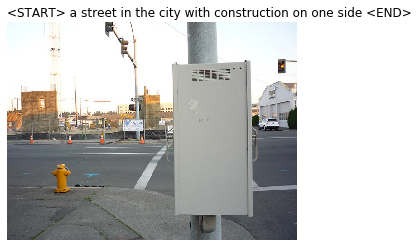

In [3]:
# Sample images and captions
captions, features, urls = sample_coco_minibatch(data, batch_size=1)
show_samples(captions, urls, data)

## Data for training

For simple test, you can load subsample of total train data.<br>
But you should use <font color=red>**full train_data**</font> for final test.<br>
You will be able to verify your captioning model more quickly with the small train data.<br>
<font color=red>**You must show loss changes with full train data**</font> when you train. <br>
And you must show maxlen, n_words, captions.shape.


In [4]:
#-------------------------------------------------------------------------
# CAUTION: Do not change maxlen(17), n_words(1004), input_dimension(512)
# you should use 512 extracted image features
# Do not change coco_utils.py
#-------------------------------------------------------------------------

#----------------------------------------------
# [case 1] subsample
# Try to subsamples of train_data for simple test
#----------------------------------------------
# train_data = load_coco_data(base_dir=data_path, max_train=500)

#----------------------------------------------
# [case 2] full train data
# Try to full train_data for real test
#----------------------------------------------
train_data = data

captions = train_data['train_captions']
img_idx  = train_data['train_image_idxs']
img_features = train_data['features'][img_idx]
word_to_idx = train_data['word_to_idx']
idx_to_word = train_data['idx_to_word']

n_words = len(word_to_idx)
maxlen = train_data['train_captions'].shape[1]
input_dimension = train_data['features'].shape[1]


print(n_words)
print(maxlen)
print(img_features.shape, captions.shape)

vcaptions = train_data['val_captions']
vimg_idx  = train_data['val_image_idxs']
vimg_features = train_data['features'][vimg_idx]
print(vimg_features.shape, vcaptions.shape)


1004
17
(400135, 512) (400135, 17)
(10000, 512) (10000, 17)


In [5]:
#################################################################################
# TODO: Implement for caption training class in captioning.py
# you should use TensorFlow RNN libraries (such as tf.contrib.rnn)
# You can modify classes, functions, parameters according to your model structure.
# You can also hide the train function in the Captioning class.
# Just show the loss changes depending on the learning procedure.
#
# class Captioning():
#     def __init(self,...):
#     def model(self,...):
#     def predict(self,...):
#################################################################################

def train(img_features, captions):
    #-------------------------------------------------------------
    # You must show maxlen, n_words, caption.shape !!
    #-------------------------------------------------------------
    print(maxlen, n_words, captions.shape)
    #################################################
    # TODO: Implement caption training
    # - save your trained model in model_path
    # - must print about 10 loss changes !!
    #################################################
    
    tf.reset_default_graph()

    config = Config()
    config.phase = 'train'
    config.save_dir = './models_captioning'
    config.caption_maxlen = maxlen
    config.word_size = n_words
    config.dim_img_features = img_features.shape[1]
    
    config.num_epochs = 200
    config.batch_size = 128
    config.learning_rate = 0.001

    with tf.Session() as sess:
        model = Captioning(config)
        sess.run(tf.global_variables_initializer())
        tf.get_default_graph().finalize()
        model.train(sess, img_features, captions)
    
    #################################################
    #                END OF YOUR CODE               #
    #################################################
    
train(img_features, captions) 


17 1004 (400135, 17)
Building the LSTM...
LSTM built.
Training...
Current Cost: 2.91 	 Epoch 1/200
Current Cost: 2.56 	 Epoch 20/200
Current Cost: 2.55 	 Epoch 40/200
Current Cost: 2.52 	 Epoch 60/200
Current Cost: 2.41 	 Epoch 80/200
Current Cost: 2.52 	 Epoch 100/200
Current Cost: 2.64 	 Epoch 120/200
Current Cost: 2.46 	 Epoch 140/200
Current Cost: 2.47 	 Epoch 160/200
Current Cost: 2.40 	 Epoch 180/200
Current Cost: 2.51 	 Epoch 200/200
 Saving the model...
The model saved.
Training done.


## Evaluation

You can test your model in train, validation samples with sample images.<br>
Final evaluation will be done with average BLEU score.<br>
BLEU (bilingual evaluation understudy) score is between 0 and 1. The values closer to 1 represents more similar texts. <br>
https://en.wikipedia.org/wiki/BLEU
<font color=red>**Your model could be evaluated without traning procedure,**</font> if you saved and loaded your model properly.


In [6]:
import tensorflow as tf
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

#import pandas as pd

import tensorflow.python.platform

from coco_utils import *
from captioning import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

model_path='./models_captioning'
data_path ='./coco/coco_captioning'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

train_data = load_coco_data()

captions = train_data['train_captions']
img_idx  = train_data['train_image_idxs']
img_features = train_data['features'][img_idx]
word_to_idx = train_data['word_to_idx']
idx_to_word = train_data['idx_to_word']
vcaptions = train_data['val_captions']
vimg_idx  = train_data['val_image_idxs']
vimg_features = train_data['features'][vimg_idx]

n_words = len(word_to_idx)
maxlen = train_data['train_captions'].shape[1]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Write your code for image captioning predicting
# The image_captioning should include following functions
# - load your saved model 
# - return predicted captions from image features

def image_captioning(features) :
    pr_captions = np.zeros((features.shape[0],maxlen),int)
    #################################################
    # TODO: Implement predicting image captioning
    # - load your saved model
    # - predict the captions
    #################################################
    
    tf.reset_default_graph()

    config = Config()
    config.phase = 'test'
    config.model_file = model_path + '/model.npy'
    config.batch_size = 1
    config.caption_maxlen = maxlen
    config.word_size = n_words
    config.dim_img_features = img_features.shape[1]
    
    with tf.Session() as sess:
        model = Captioning(config)
        model.load(sess, config.model_file)        
        tf.get_default_graph().finalize()
        pr_captions = model.predict(sess, features)
            
    #################################################
    #                END OF YOUR CODE               #
    #################################################
    return pr_captions

Building the LSTM...
LSTM built.
Loading the model...
The model loaded.


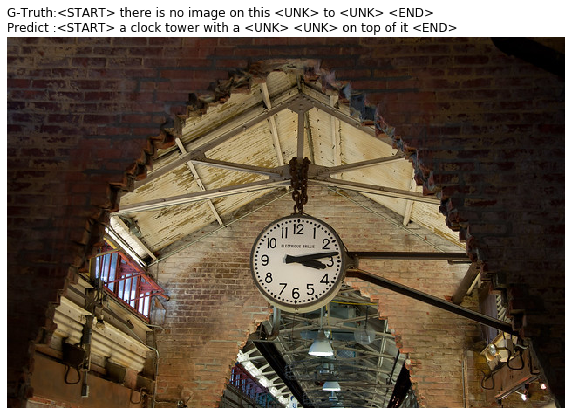

Building the LSTM...
LSTM built.
Loading the model...
The model loaded.


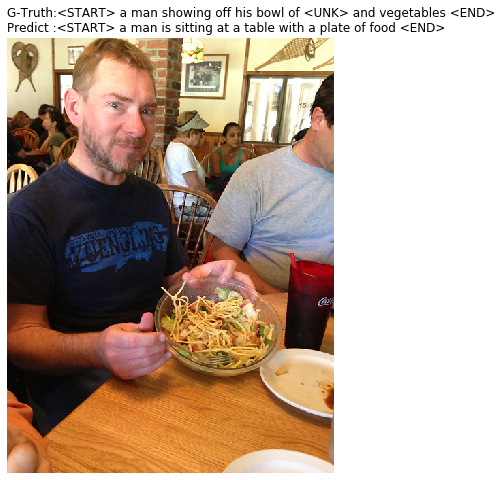

In [8]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(train_data, split=split, batch_size=1)

    gt_captions, features, urls = minibatch
    pr_captions = image_captioning(features)

    show_predict_samples(gt_captions, pr_captions, urls, train_data)

In [9]:
# Prints unigram BLEU score averaged over val dataset

def evaluate_model(data, split):
    BLEUscores = {}

    minibatch = sample_coco_minibatch(data, split=split, batch_size="All")
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    pr_captions = image_captioning(features)
    pr_captions = decode_captions(pr_captions, data['idx_to_word'])

    total_score = 0.0
        
    for gt_caption, pr_caption, url in zip(gt_captions, pr_captions, urls):
        total_score += BLEU_score(gt_caption, pr_caption)

    BLEUscores[split] = total_score / len(pr_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))


In [10]:
evaluate_model(train_data,'val')

Total captions: 10000
Building the LSTM...
LSTM built.
Loading the model...
The model loaded.
Average BLEU score for val: 0.344317


In [11]:
# This cell is for TA, TA will evaluate your model with independent test_data
# the number of captions of test_data is about 200,000
# you should handle captions up to 200,000

#evaluate_model(test_data,'test')

